In [2]:
import math
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import wandb
from wandb.keras import WandbCallback

print(tf.__version__)

2.7.0


In [3]:
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

In [4]:
tf.config.list_physical_devices('GPU')

[]

In [5]:
data_news_headlines = pd.read_json("../shared_data/x1.json")

# Adjust news headline data
data_news_headlines = data_news_headlines.drop(columns='article_link', axis=1)
data_news_headlines = data_news_headlines.rename(columns ={'headline':'text', 'is_sarcastic':'label'})
data_news_headlines = data_news_headlines.reindex(columns=['text','label'])
data_news_headlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    28619 non-null  object
 1   label   28619 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 447.3+ KB


In [6]:
data_tweets = pd.read_csv("../shared_data/dataset_csv.csv")

# Adjust tweets data
data_tweets = data_tweets.rename(columns={'tweets':'text'})
data_tweets.head()

,text,label
0,I love working midnights tweet,1
1,I hate when I buy a bag of air and there's chi...,1
2,my grandad always sounds so ill when i speak t...,0
3,"I realize I'm annoying to everyone, so I won't...",0
4,I love when I find these dudes on vine!! #Foll...,1


In [7]:
data_sitcoms = pd.read_csv("../shared_data/mustard++_text.csv")

# Adjust sitcom data
data_sitcoms = data_sitcoms.drop(columns=['SCENE','KEY','END_TIME','SPEAKER','SHOW','Sarcasm_Type','Implicit_Emotion','Explicit_Emotion','Valence','Arousal'], axis=1)
data_sitcoms = data_sitcoms.rename(columns={'SENTENCE':'text','Sarcasm':'label'})

# remove empty label rows
for index, row in data_sitcoms.iterrows():
    if math.isnan(row['label']):
        data_sitcoms = data_sitcoms.drop(index, axis='index')

data_sitcoms.head()

,text,label
5,"And of those few months, how long have you bee...",0.0
14,"Let the dead man talk. So, why do you think that?",0.0
18,"What else? Sell it on eBay as ""slightly used.""",0.0
24,"Good idea, sit with her. Hold her, comfort her...",1.0
31,"Well, now that I've given up string theory, I'...",0.0


In [8]:
data_reddit = pd.read_csv("../shared_data/train-balanced-sarcasm.csv")

# Adjust reddit data
data_reddit = data_reddit.drop(columns=['author','subreddit','score','ups','downs','date','created_utc','parent_comment'], axis=1)
data_reddit = data_reddit.rename(columns={'comment':'text'})
data_reddit = data_reddit.reindex(columns=['text','label'])

data_reddit.head()

,text,label
0,NC and NH.,0
1,You do know west teams play against west teams...,0
2,"They were underdogs earlier today, but since G...",0
3,"This meme isn't funny none of the ""new york ni...",0
4,I could use one of those tools.,0


Set News Headlines dataset variables

In [9]:
subset_size = len(data_tweets.index)
testing_size = int(subset_size * 0.2)
validation_size = testing_size
shuffle_size = subset_size - validation_size

data_batch_size = 32

Shuffle the data and set the train and test splits

In [10]:
data = data_tweets.sample(frac=1).reset_index(drop=True)
train_data = data.head(subset_size - testing_size)
test_data = data.tail(testing_size)

In [11]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (
        train_data['text'][validation_size:], 
        train_data['label'][validation_size:]
    )
).shuffle(shuffle_size).batch(data_batch_size)

val_ds = tf.data.Dataset.from_tensor_slices(
    (
        train_data['text'][:validation_size],
        train_data['label'][:validation_size]
    )
).batch(data_batch_size)

test_ds = tf.data.Dataset.from_tensor_slices(
    (
        test_data['text'],
        test_data['label']
    )
)

text_vocab_ds = tf.data.Dataset.from_tensor_slices(train_data['text'])

Set training variables

In [12]:
epochs = 10

##define the parameters for tokenizing and padding
vocab_size = 10000
embedding_dim = 32
max_length = 120

Initialize and config the Weights and Biases graphing library

In [13]:
wandb.init(project="sarcasmscanner", entity="awesomepossum")

wandb.config = {
    "epochs": epochs,
    "vocab_size": vocab_size,
    "embedding_dim": embedding_dim,
    "max_sentence_word_length": max_length,
    "batch_size": data_batch_size,
    "subset_size": subset_size,
    "training_size": subset_size - testing_size - validation_size,
    "testing_size": testing_size,
    "validation_size": validation_size,
    "dataset": "news_headlines",
    "architecture": "LSTM"
}

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ilp9 (awesomepossum). Use `wandb login --relogin` to force relogin


Create the text vectorization layer and create the vocab

In [14]:
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=vocab_size, standardize='lower_and_strip_punctuation', split='whitespace', output_mode='int', output_sequence_length=max_length)

vectorize_layer.adapt(text_vocab_ds.batch(data_batch_size))

Create the Model

In [15]:
model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 120)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 120, 32)           320000    
                                                                 
 bidirectional (Bidirectiona  (None, 120, 128)         49664     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                        

Train the model

In [16]:
history = model.fit(x=train_ds,
                        validation_data=val_ds,
                        epochs=epochs,
                        callbacks=[WandbCallback()])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/10
38/38 [==============================] - ETA: 0s - loss: 0.6650 - accuracy: 0.5776

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: c:\Users\ingri\Documents\GitHub\ScannerTraining\Hartzler\wandb\run-20221024_081513-1f31ux7b\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\ingri\Documents\GitHub\ScannerTraining\Hartzler\wandb\run-20221024_081513-1f31ux7b\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\ingri\Documents\GitHub\ScannerTraining\Hartzler\wandb\run-20221024_081513-1f31ux7b\files\model-best)... Done. 0.4s


38/38 [==============================] - 188s 5s/step - loss: 0.6650 - accuracy: 0.5776 - val_loss: 0.5447 - val_accuracy: 0.7538
Epoch 2/10
38/38 [==============================] - ETA: 0s - loss: 0.3200 - accuracy: 0.8865

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: c:\Users\ingri\Documents\GitHub\ScannerTraining\Hartzler\wandb\run-20221024_081513-1f31ux7b\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\ingri\Documents\GitHub\ScannerTraining\Hartzler\wandb\run-20221024_081513-1f31ux7b\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\ingri\Documents\GitHub\ScannerTraining\Hartzler\wandb\run-20221024_081513-1f31ux7b\files\model-best)... Done. 0.3s


38/38 [==============================] - 176s 5s/step - loss: 0.3200 - accuracy: 0.8865 - val_loss: 0.2910 - val_accuracy: 0.9045
Epoch 3/10
38/38 [==============================] - ETA: 0s - loss: 0.1693 - accuracy: 0.9449

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: c:\Users\ingri\Documents\GitHub\ScannerTraining\Hartzler\wandb\run-20221024_081513-1f31ux7b\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\ingri\Documents\GitHub\ScannerTraining\Hartzler\wandb\run-20221024_081513-1f31ux7b\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\ingri\Documents\GitHub\ScannerTraining\Hartzler\wandb\run-20221024_081513-1f31ux7b\files\model-best)... Done. 0.3s


38/38 [==============================] - 188s 5s/step - loss: 0.1693 - accuracy: 0.9449 - val_loss: 0.2824 - val_accuracy: 0.9070
Epoch 4/10
38/38 [==============================] - 135s 3s/step - loss: 0.1096 - accuracy: 0.9658 - val_loss: 0.3437 - val_accuracy: 0.8894
Epoch 5/10
38/38 [==============================] - 84s 2s/step - loss: 0.0693 - accuracy: 0.9850 - val_loss: 0.3390 - val_accuracy: 0.9020
Epoch 6/10
38/38 [==============================] - 85s 2s/step - loss: 0.0497 - accuracy: 0.9883 - val_loss: 0.3684 - val_accuracy: 0.8844
Epoch 7/10
38/38 [==============================] - 84s 2s/step - loss: 0.0254 - accuracy: 0.9950 - val_loss: 0.4825 - val_accuracy: 0.8693
Epoch 8/10
38/38 [==============================] - 96s 3s/step - loss: 0.0215 - accuracy: 0.9950 - val_loss: 0.5221 - val_accuracy: 0.8668
Epoch 9/10
38/38 [==============================] - 93s 2s/step - loss: 0.0091 - accuracy: 0.9983 - val_loss: 0.5688 - val_accuracy: 0.8417
Epoch 10/10
38/38 [==========

<!-- , -->
<!-- callbacks=[WandbCallback()] -->

Test the model

In [17]:
loss, accuracy = model.evaluate(test_ds.batch(32))

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

13/13 [==============================] - 10s 802ms/step - loss: 0.4550 - accuracy: 0.8995
Loss: 0.45499202609062195
Accuracy: 0.8994975090026855


Plot the accuracy and loss over time

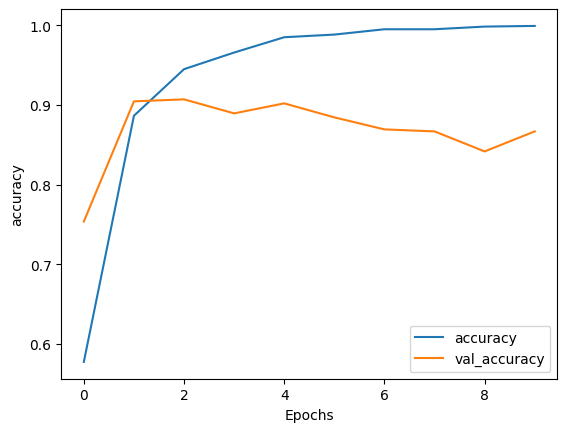

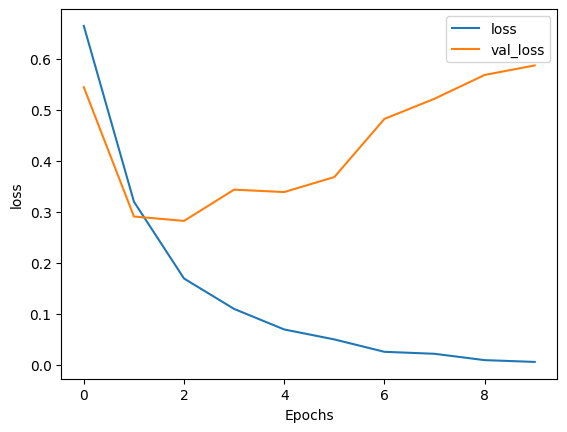

In [18]:
def plot_metrics(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric])
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()
  
plot_metrics(history, "accuracy")
plot_metrics(history, "loss")

Export for inference

In [19]:
saved_model_path = './model_saves/lstm_v2/'
model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./model_saves/lstm_v2/assets


INFO:tensorflow:Assets written to: ./model_saves/lstm_v2/assets


Reload and test inference

In [20]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [21]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

def print_my_examples(inputs, results):
  for i in range(len(inputs)):
    print('input: ', inputs[i], ' : score: ', results.numpy()[i][0], ' : rounded: ', round(results.numpy()[i][0]))
  print()


examples = [
    "Please, keep talking. I always yawn when I am interested.", # expect 1
    "Well, what a surprise.", # expect 1
    "Really, Sherlock? No! You are clever.", # expect 1
    "The quick brown fox jumps over the lazy dog", # expect 0
    "Numerous references to the phrase have occurred in movies, television, and books." # expect 0
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input:  Please, keep talking. I always yawn when I am interested.  : score:  0.7307519  : rounded:  1
input:  Well, what a surprise.  : score:  0.7308143  : rounded:  1
input:  Really, Sherlock? No! You are clever.  : score:  0.60568535  : rounded:  1
input:  The quick brown fox jumps over the lazy dog  : score:  0.53446186  : rounded:  1
input:  Numerous references to the phrase have occurred in movies, television, and books.  : score:  0.7260906  : rounded:  1

Results from the model in memory:
input:  Please, keep talking. I always yawn when I am interested.  : score:  0.7307519  : rounded:  1
input:  Well, what a surprise.  : score:  0.7308143  : rounded:  1
input:  Really, Sherlock? No! You are clever.  : score:  0.60568535  : rounded:  1
input:  The quick brown fox jumps over the lazy dog  : score:  0.53446186  : rounded:  1
input:  Numerous references to the phrase have occurred in movies, television, and books.  : score:  0.7260906  : rounded:  1

